In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image


In [7]:


class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # Assume three categories with some possible values
        self.label_map = {
            'good': 0, 'bad': 1, 
            'cell_type_A549': 2, 'cell_type_CACO': 3, 'cell_type_HPMEC': 4, 'cell_type_HSAEC': 5, 'cell_type_HUVEC' : 6, 'cell_type_NHBE' : 7,
            '0-1_days': 8, '2-3_days': 9, '4_days': 10, '4+_days': 11
        }
        num_total_labels = len(self.label_map)  # Total number of labels

        for main_label in ['good', 'bad']:
            main_label_dir = os.path.join(root_dir, main_label)
            for cell_type in os.listdir(main_label_dir):
                cell_type_dir = os.path.join(main_label_dir, cell_type)
                for age in os.listdir(cell_type_dir):
                    age_dir = os.path.join(cell_type_dir, age)
                    for img_file in os.listdir(age_dir):
                        img_path = os.path.join(age_dir, img_file)
                        label_vector = [0] * num_total_labels
                        label_vector[self.label_map[main_label]] = 1
                        label_vector[self.label_map[cell_type]] = 1
                        label_vector[self.label_map[age]] = 1
                        self.samples.append((img_path, label_vector))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_vector = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label_vector, dtype=torch.float32)


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Modify the path according to your dataset structure
train_data = MultiLabelDataset('../OOC_image_dataset/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=14, shuffle=True)

validate_data = MultiLabelDataset('../OOC_image_dataset/val', transform=transform)
validate_loader = DataLoader(validate_data, batch_size=14, shuffle=False)

test_data = MultiLabelDataset('../OOC_image_dataset/test', transform=transform)
test_loader = DataLoader(test_data, batch_size=14, shuffle=False)


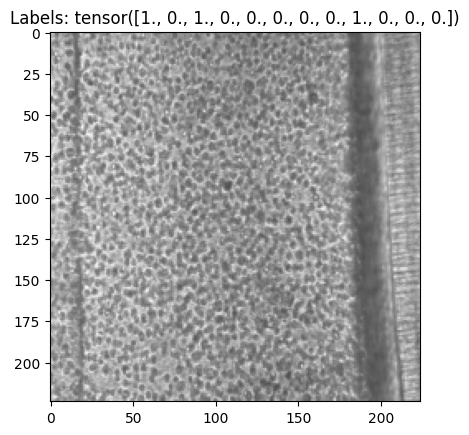

In [10]:
import matplotlib.pyplot as plt

def show_image(image_tensor, labels):
    # Inverse normalize the image
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image_tensor.permute(1, 2, 0) * std + mean
    image = torch.clamp(image, 0, 1)
    plt.imshow(image)
    plt.title(f'Labels: {labels}')
    plt.show()


dataset = MultiLabelDataset('../OOC_image_dataset/train', transform=transform)
image, labels = dataset[0]  # Get the first sample
show_image(image, labels)

In [11]:
mobilenet = models.mobilenet_v2(pretrained=True)

num_classes = 2 + 6 + 4
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)


c:\Users\Roberts\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Roberts\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}: Train Loss: {loss.item()}, Val Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy}%')


In [14]:
train_model(mobilenet, train_loader, validate_loader, criterion, optimizer, num_epochs=10)


KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    total = correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

evaluate_model(mobilenet, test_loader)


KeyboardInterrupt: 